In [23]:
import gradio as gr
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random


DATA PREPROCESSING


In [7]:
movies=pd.read_csv('/content/movie.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies.info()
movies.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


(27278, 3)

In [10]:
movies.isnull().sum()

,0
movieId,0
title,0
genres,0


In [12]:
unique_genres = set("|".join(movies["genres"]).split("|"))
print("Unique Genres:", unique_genres)


Unique Genres: {'Mystery', 'Action', 'Western', '(no genres listed)', 'Sci-Fi', 'Documentary', 'Musical', 'Thriller', 'Crime', 'Comedy', 'Animation', 'Fantasy', 'IMAX', 'Children', 'Drama', 'Film-Noir', 'War', 'Romance', 'Adventure', 'Horror'}


<ipython-input-14-de3b596aff54>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_df["Count"], y=genre_df["Genre"], palette="viridis")


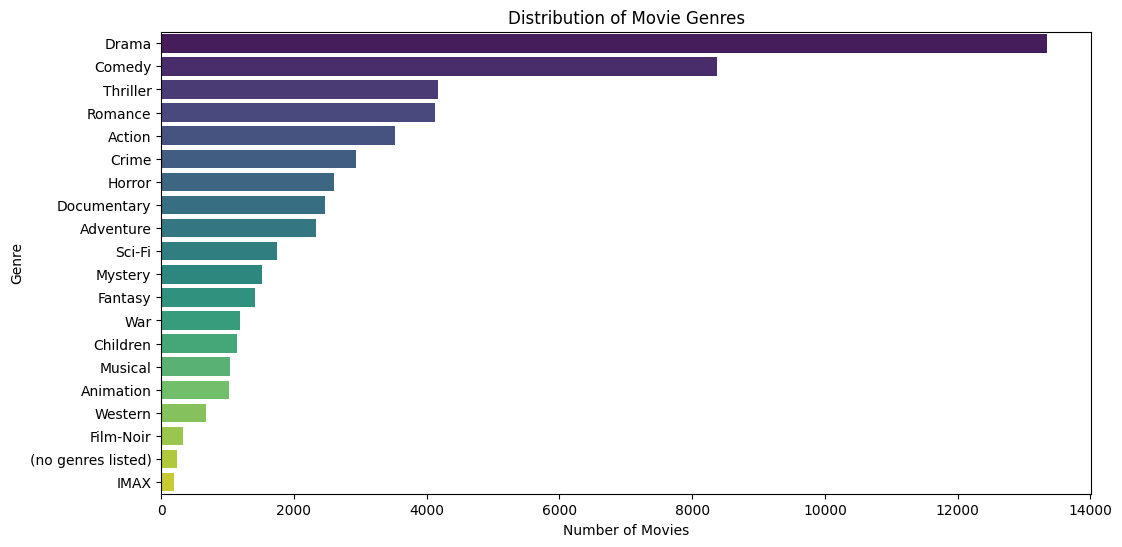

In [14]:
all_genres = "|".join(movies["genres"]).split("|")
genre_counts = Counter(all_genres)

genre_df = pd.DataFrame(genre_counts.items(), columns=["Genre", "Count"]).sort_values(by="Count", ascending=False)


plt.figure(figsize=(12,6))
sns.barplot(x=genre_df["Count"], y=genre_df["Genre"], palette="viridis")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Distribution of Movie Genres")
plt.show()


In [17]:
no_genre_count = (movies["genres"] == "(no genres listed)").sum()
print(f"Movies without a genre: {no_genre_count}")


Movies without a genre: 246


In [18]:
no_genre_movies = movies[movies["genres"] == "(no genres listed)"]
print(no_genre_movies[["movieId", "title"]])


       movieId                                            title
16574    83773            Away with Words (San tiao ren) (1999)
16589    83829                            Scorpio Rising (1964)
16764    84768                                Glitterbug (1994)
17080    86493  Age of the Earth, The (A Idade da Terra) (1980)
17243    87061                          Trails (Veredas) (1978)
...        ...                                              ...
27216   131082                                Playground (2009)
27229   131108                         The Fearless Four (1997)
27258   131166                                WWII IN HD (2009)
27261   131172                            Closed Curtain (2013)
27276   131260                              Rentun Ruusu (2001)

[246 rows x 2 columns]


In [19]:
movies.loc[movies["genres"] == "(no genres listed)", "genres"] = "Miscellaneous"


**CONTENT** **BASED** **FILTERING** - TF-IDF and Cosine Similarity

In [21]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies["genres"])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [25]:
def recommend_by_genre(genre, top_n=5):
    # Filter movies that contain the genre
    genre_movies = movies[movies["genres"].str.contains(genre, case=False, na=False)]

    # If no movies are found, return an error message
    if genre_movies.empty:
        return "Genre not found. Please enter a valid genre."

    # Randomly sample movies from the genre (up to top_n)
    return genre_movies.sample(n=min(top_n, len(genre_movies)))[["title", "genres"]]

# Example search
print(recommend_by_genre("Sci-Fi", 5))
print(recommend_by_genre("Comedy", 5))

                                                   title  \
11400                             Children of Men (2006)   
12724                                Flesh Gordon (1974)   
16633                                        Five (1951)   
16647  Evangelion: 2.0 You Can (Not) Advance (Evanger...   
21963                       Rebirth of Mothra III (1998)   

                                       genres  
11400  Action|Adventure|Drama|Sci-Fi|Thriller  
12724                 Adventure|Comedy|Sci-Fi  
16633                     Drama|Horror|Sci-Fi  
16647           Action|Animation|Drama|Sci-Fi  
21963                   Action|Fantasy|Sci-Fi  
                                                   title                genres
20182                   Move (3 Zimmer/Küche/Bad) (2012)          Comedy|Drama
5411                         24 Hour Party People (2002)  Comedy|Drama|Musical
1391                             Fierce Creatures (1997)                Comedy
6187   Man Without a Past, The (Mie

In [27]:
# Gradio Interface

def genre_recommender(selected_genre):
    recommendations = recommend_by_genre(selected_genre)
    return "\n".join(recommendations["title"].tolist())

# Get unique genres from the dataset
unique_genres = set("|".join(movies["genres"]).split("|"))

# Create Gradio UI
interface = gr.Interface(
    fn=genre_recommender,
    inputs=gr.Dropdown(choices=list(unique_genres), label="Select a Genre"),
    outputs="text",
    title="🎬 Genre-Based Movie Recommendation System",
    description="Select a genre to get movie recommendations!"
)

# Launch the app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a543655a564be66cfd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
